***
### ANALYSIS OF `US-ACCIDENTS-DATA.CSV` TO FIND FACTORS THAT AFFECT THE LENGTH OF THE ROAD AFFECTED BY CAR ACCIDENTS.
***

In [1]:
# Import libraries
import sqlite3
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import matplotlib.ticker as ticker
import matplotlib.patches as mpatches
%matplotlib inline
import calendar
import plotly as pt
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
from pylab import *
import matplotlib.patheffects as PathEffects

import descartes
import geopandas as gpd
from Levenshtein import distance
from itertools import product
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
from scipy.spatial.distance import pdist, squareform
from shapely.geometry import Point, Polygon

#import geoplot
from geopy.geocoders import Nominatim

import warnings
warnings.filterwarnings('ignore')

C:\Users\Charles\anaconda3\envs\MA336_environment\lib\site-packages\requests\__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.2.0)/charset_normalizer (2.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


## 1.

#### Import and inspect the dataset

In [ ]:
accidents = pd.read_excel('accidents.xlsx')

In [42]:
# Save a copy of the data in memory so we don't have to re-import
accidents_copy = accidents.copy()

In [43]:
# For making copies to prevent having to reimport the data 
# accidents = accidents_copy.copy()

In [44]:
# Inspect the first 5 rows of the dataset
accidents.head()

,Unnamed: 0,ID,Source,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,...,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight,Unnamed: 47
0,0,A-3650461,Source1,2,2023-03-31 17:09:16,2023-03-31 18:09:49,45.676472,-94.174568,45.666976,-94.176184,...,0.0,0.0,0.0,0.0,False,Day,Day,Day,Day,NaN
1,1,A-3650462,Source1,2,2023-02-27 20:55:00,2023-02-27 23:36:34,41.391812,-75.467365,41.39837,-75.484203,...,0.0,0.0,0.0,0.0,False,Night,Night,Night,Night,NaN
2,2,A-3650463,Source1,2,2023-02-26 09:31:45,2023-02-26 11:58:19,40.850278,-73.94614,40.846945,-73.933651,...,0.0,0.0,0.0,0.0,False,Day,Day,Day,Day,NaN
3,3,A-3650464,Source1,2,2023-03-21 17:46:42,2023-03-21 18:31:50,33.714992,-84.300188,33.714532,-84.266758,...,0.0,0.0,0.0,0.0,False,Day,Day,Day,Day,NaN
4,4,A-3650465,Source1,2,2023-03-24 04:46:30,2023-03-24 09:22:00,33.927671,-118.266385,33.929608,-118.343065,...,0.0,0.0,0.0,0.0,False,Night,Night,Night,Night,NaN


#### Data Preprocessing

We will proceed to gather the following information about the dataset
* Missing values
* Null values
* Type of data in the file
* Statistical summary of each numeric column

In [45]:
# Drop the first (index) and last columns (since it contains over 90% null values)
accidents = accidents.iloc[:, 1:-1]

In [46]:
# check the columns in the data
accidents.columns

Index(['ID', 'Source', 'Severity', 'Start_Time', 'End_Time', 'Start_Lat',
       'Start_Lng', 'End_Lat', 'End_Lng', 'Distance(mi)', 'Description',
       'Street', 'City', 'County', 'State', 'Zipcode', 'Country', 'Timezone',
       'Airport_Code', 'Weather_Timestamp', 'Temperature_Range(F)',
       'Wind_Chill(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)',
       'Wind_Direction', 'Wind_Speed(mph)', 'Precipitation(in)',
       'Weather_Condition', 'Amenity', 'Bump', 'Crossing', 'Give_Way',
       'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop',
       'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop', 'Sunrise_Sunset',
       'Civil_Twilight', 'Nautical_Twilight', 'Astronomical_Twilight'],
      dtype='object')

In [47]:
# Query the shape of the data
shape = accidents.shape

print('Number of columns: ', shape[1])
print('Number of rows: ', shape[0])

Number of columns:  46
Number of rows:  246665


#### Handling Missing Values

Missing values in the dataset might have been caused by a variety of reasons, such as data collection errors, incomplete data, or data not being recorded. Handling missing values is crucial to avoid bias and ensure accuracy of our analysis. Different methods can usually be used to address missing values. In this project, we will use the `dropna()` method of the pandas dataframe class. This method is appropriate because the ratio of missing values is relatively small and the dataset does not lend itself well to other methods such as mean inputation.

In [48]:
accidents.isnull().sum()

ID                           0
Source                       0
Severity                     0
Start_Time                   0
End_Time                     0
Start_Lat                    0
Start_Lng                    0
End_Lat                      0
End_Lng                      0
Distance(mi)                 0
Description                  0
Street                     796
City                        34
County                      32
State                       32
Zipcode                     91
Country                     32
Timezone                   261
Airport_Code               920
Weather_Timestamp         5368
Temperature_Range(F)      6208
Wind_Chill(F)             8308
Humidity(%)               6777
Pressure(in)              5698
Visibility(mi)            6902
Wind_Direction            7815
Wind_Speed(mph)           7812
Precipitation(in)        11238
Weather_Condition         6649
Amenity                     32
Bump                        36
Crossing                    36
Give_Way

In [49]:
accidents = accidents.dropna(how = 'all', subset = [col for col in accidents.columns if col != 'Temperature_Range(F)'])
print(f'The dataset now contains {len(accidents)} after dropping null values')

The dataset now contains 246665 after dropping null values


In [50]:
# Drop duplicate records taking the 'ID' column into consideration as it is the unique identifier of each accident
accidents = accidents.drop_duplicates(subset = 'ID')

print(f'The dataset now contains {len(accidents)} after dropping null values')

The dataset now contains 246647 after dropping null values


In [51]:
# Inspect the structure of the data
accidents.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 246647 entries, 0 to 246664
Data columns (total 46 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   ID                     246647 non-null  object 
 1   Source                 246647 non-null  object 
 2   Severity               246647 non-null  object 
 3   Start_Time             246647 non-null  object 
 4   End_Time               246647 non-null  object 
 5   Start_Lat              246647 non-null  object 
 6   Start_Lng              246647 non-null  object 
 7   End_Lat                246647 non-null  object 
 8   End_Lng                246647 non-null  object 
 9   Distance(mi)           246647 non-null  object 
 10  Description            246647 non-null  object 
 11  Street                 245851 non-null  object 
 12  City                   246613 non-null  object 
 13  County                 246615 non-null  object 
 14  State                  246615 non-nu

In [52]:
accidents = accidents[accidents['Timezone'].isin(
    ['central', 'eastern', 'pacific', 'Pacific', 
    'mountain','us/pacific', 'Eastern', 'Central', 
    'us/eastern', 'US/Pacific', 'us/central', 'Mountain', 
    'us/mountain', nan, 'US/Central', 'US/Eastern', 'US/Mountain'])]

## 2.

## Exploratory Data Analysis and Insights

### SPATIAL ANALYSIS

#### Interactive Map of approximate location of accident

In [53]:
import folium
from folium.plugins import MarkerCluster
import random

In [54]:
# Sampling a smaller subset of the data for faster map generation
sampled_accidents_df = accidents.sample(n=5000, random_state=42)

# Create a folium map centered on the US
us_map_sampled = folium.Map(location=[37.0902, -95.7129], zoom_start=5)

# Add a marker cluster to the map
marker_cluster_sampled = MarkerCluster().add_to(us_map_sampled)

# Add points to the marker cluster
for idx, row in sampled_accidents_df.iterrows():
    folium.Marker([row['Start_Lat'], row['Start_Lng']]).add_to(marker_cluster_sampled)

# Save the map as an HTML file
us_map_sampled


#### Which City in US has reported most number of Accidents

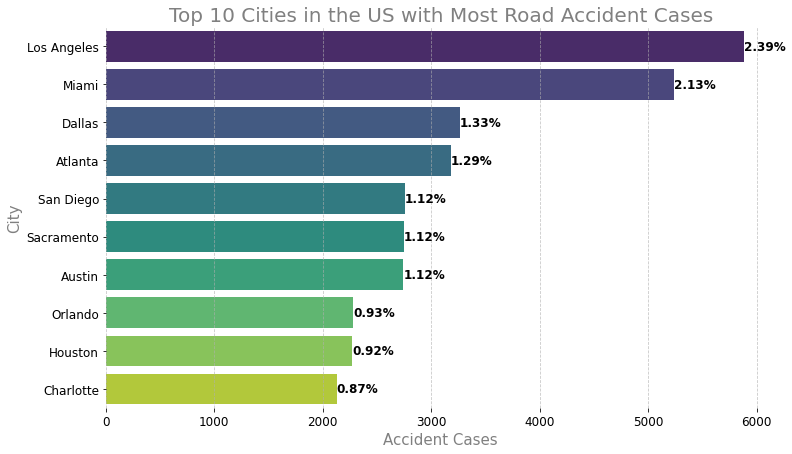

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare the data for top 10 cities
top_10_cities = accidents['City'].value_counts().nlargest(10).reset_index()
top_10_cities.columns = ['City', 'Cases']

# Calculate the total number of cases
total_cases = accidents['City'].value_counts().sum()

# Create the plot
plt.figure(figsize=(12, 7))
sns.barplot(x='Cases', y='City', data=top_10_cities, palette='viridis')

# Adding annotations with percentage at the top of each bar
for index, value in enumerate(top_10_cities['Cases']):
    percentage = (value / total_cases) * 100
    plt.text(value, index, f'{percentage:.2f}%', va='center', ha='left', color='black', fontsize=12, weight='bold')

# Adding titles and labels
plt.title('Top 10 Cities in the US with Most Road Accident Cases', fontsize=20, color='grey')
plt.xlabel('Accident Cases', fontsize=15, color='grey')
plt.ylabel('City', fontsize=15, color='grey')

# Customize the plot appearance
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
sns.despine(left=True, bottom=True)

plt.show()




**Insights**
* `Los Angeles` is the city with highest number of road accidents in US approximately `2.39%`.

* `Miami` is the city with the second highest number of road accidents in US approximately `2.13%`.

* These 10 cities account for approximately `13.22%` of total accidents in US.

#### Which City in US has reported Least number of Accidents

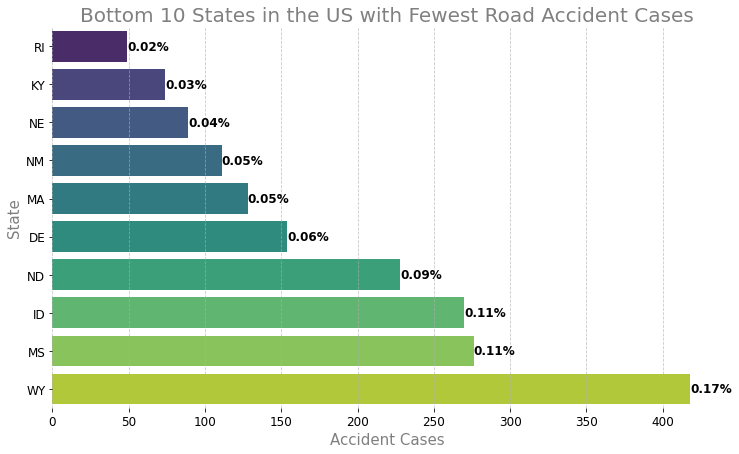

In [56]:
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare the data for the 10 states with the lowest number of accidents
bottom_10_states = accidents['State'].value_counts().nsmallest(10).reset_index()
bottom_10_states.columns = ['State', 'Cases']

# Calculate the total number of cases
total_cases = accidents['State'].value_counts().sum()

# Create the plot
plt.figure(figsize=(12, 7))
sns.barplot(x='Cases', y='State', data=bottom_10_states, palette='viridis')

# Adding annotations with percentage at the top of each bar
for index, value in enumerate(bottom_10_states['Cases']):
    percentage = (value / total_cases) * 100
    plt.text(value, index, f'{percentage:.2f}%', va='center', ha='left', color='black', fontsize=12, weight='bold')

# Adding titles and labels
plt.title('Bottom 10 States in the US with Fewest Road Accident Cases', fontsize=20, color='grey')
plt.xlabel('Accident Cases', fontsize=15, color='grey')
plt.ylabel('State', fontsize=15, color='grey')

# Customize the plot appearance
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
sns.despine(left=True, bottom=True)

plt.show()


**Insights**
* `Rhodes Island` is the state with the least number of road accidents in the US having approximately `0.02%` of incidents.

* `Kentucky` comes in with the second lowest number of road accidents in the US having approximately `0.03%` of incidents

#### Accidents in US by Severity

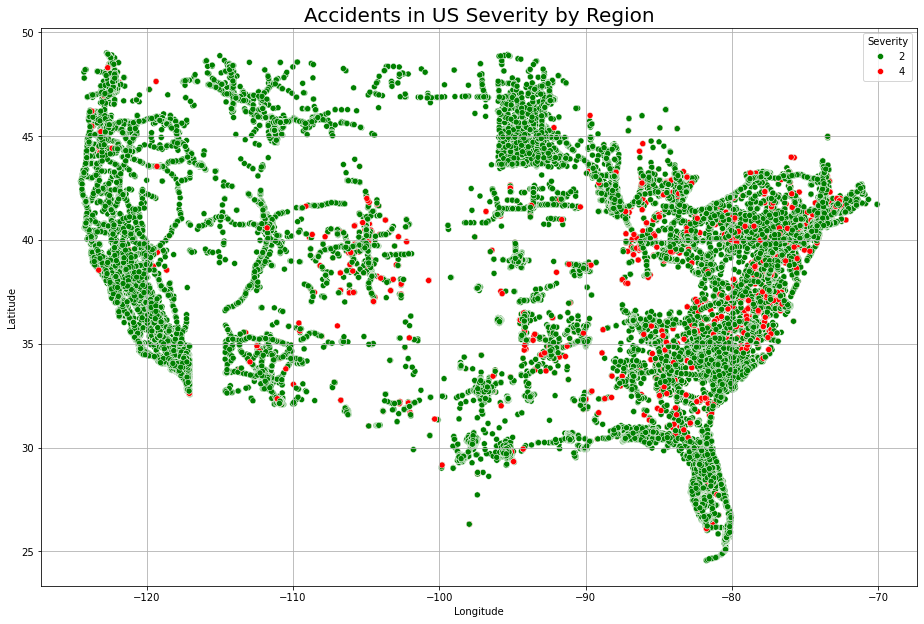

In [121]:
fig, ax = plt.subplots(figsize = (15.7,10.27))
_severity = ['1', '2', '3', '4']


sns.scatterplot(data = accidents, x = "Start_Lng", y = "Start_Lat", hue = 'Severity', palette = ['green','red'])

plt.title("Accidents in US Severity by Region", fontsize = 20)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid()

* It can be seen from the map above that the eastern part of the US is more prone to severe road accidents that the western part of the country.

### Accidents by road condition

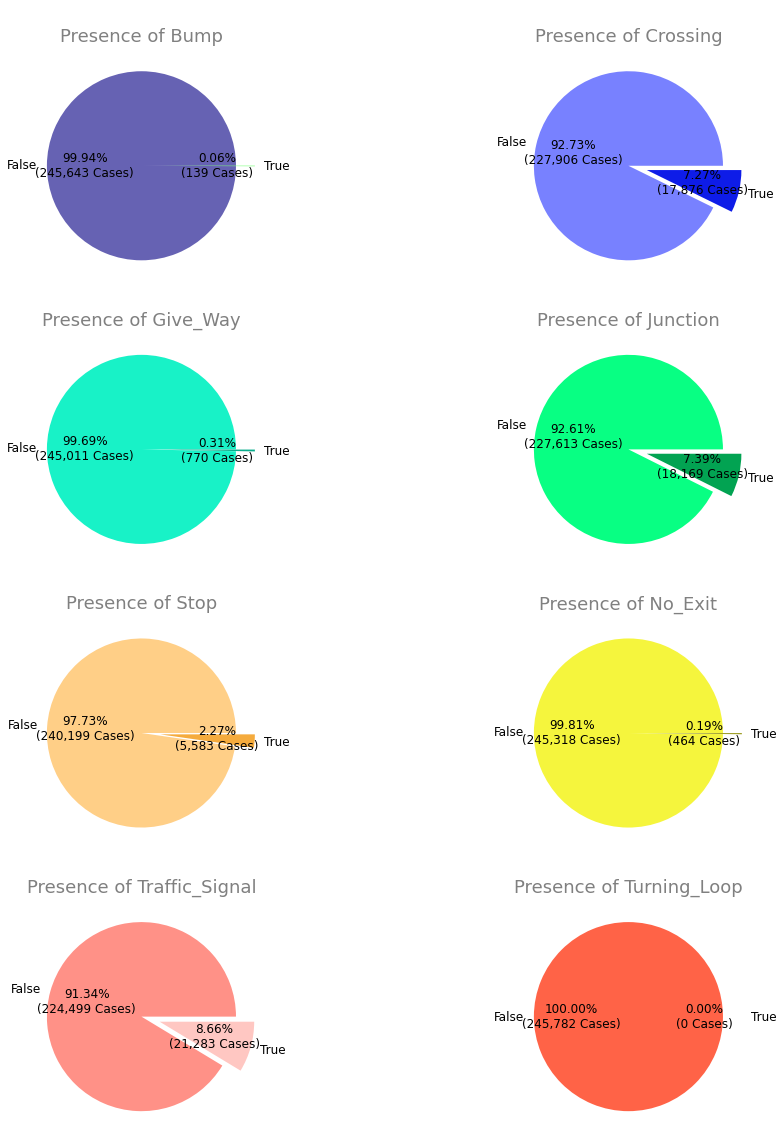

In [125]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8)) = plt.subplots(nrows=4, ncols=2, figsize=(16, 20))

road_conditions = ['Bump', 'Crossing', 'Give_Way', 'Junction', 'Stop', 'No_Exit', 'Traffic_Signal', 'Turning_Loop']
colors = [('#6662b3', '#00FF00'), ('#7881ff', '#0e1ce8'), ('#18f2c7', '#09ad8c'), ('#08ff83', '#02a352'), ('#ffcf87', '#f5ab3d'),
         ('#f5f53d', '#949410'), ('#ff9187', '#ffc7c2'), ('tomato', '#008000')]    
count = 0

def func(pct, allvals):
    absolute = int(round(pct/100*np.sum(allvals), 2))
    return "{:.2f}%\n({:,d} Cases)".format(pct, absolute)    

for i in [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8]:
    
    size = list(accidents[road_conditions[count]].value_counts())
    if len(size) != 2:
        size.append(0)
    
    labels = ['False', 'True']
    
    i.pie(size, labels=labels, colors=colors[count],
          autopct=lambda pct: func(pct, size), labeldistance=1.1,
          textprops={'fontsize': 12}, explode=[0, 0.2])

    title = '\nPresence of {}'.format(road_conditions[count])
    i.set_title(title, fontsize=18, color='grey')
    
    count += 1

# Save the figure to a file
plt.savefig('road_conditions_analysis.png', bbox_inches='tight')


#### The 3 Road Conditions Most Associated With Accidents Are:
* Traffic Signal - associated with for 8.66% of incidents
* Presence of Traffic Signal associated with 7.39%
* Presence of Crossing - associated with 7.27% of incidents

## TEMPORAL ANALYSIS

In [58]:
accidents['Start_Time'] = pd.to_datetime(accidents['Start_Time'])

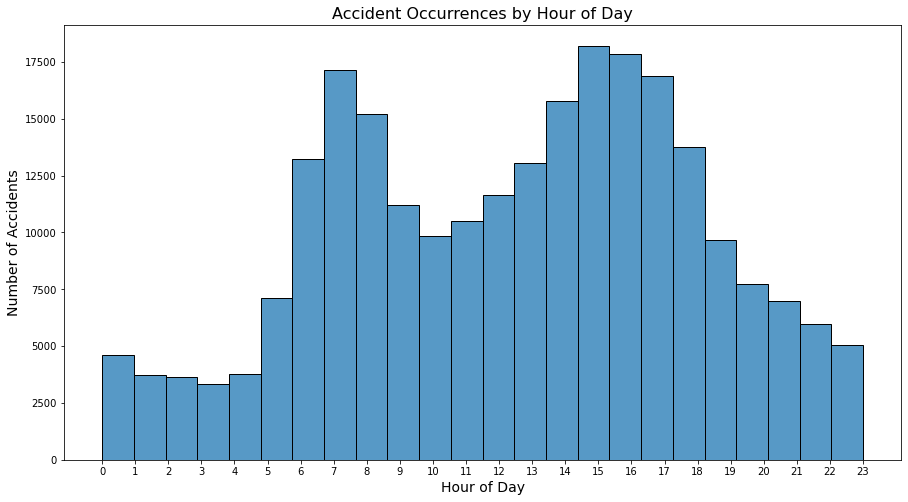

In [124]:
plt.figure(figsize=(15, 8))  # Increase figure size to make the graph larger
sns.histplot(accidents['Start_Time'].dt.hour, bins=24)
plt.title('Accident Occurrences by Hour of Day', fontsize=16)
plt.xlabel('Hour of Day', fontsize=14)
plt.ylabel('Number of Accidents', fontsize=14)
plt.xticks(np.arange(0, 24, 1))
plt.show()

In [60]:
accidents.head()

,ID,Source,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),...,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
0,A-3650461,Source1,2,2023-03-31 17:09:16,2023-03-31 18:09:49,45.676472,-94.174568,45.666976,-94.176184,0.661,...,0.0,0.0,0.0,0.0,0.0,False,Day,Day,Day,Day
1,A-3650462,Source1,2,2023-02-27 20:55:00,2023-02-27 23:36:34,41.391812,-75.467365,41.39837,-75.484203,0.983,...,0.0,0.0,0.0,0.0,0.0,False,Night,Night,Night,Night
2,A-3650463,Source1,2,2023-02-26 09:31:45,2023-02-26 11:58:19,40.850278,-73.94614,40.846945,-73.933651,0.692,...,0.0,0.0,0.0,0.0,0.0,False,Day,Day,Day,Day
3,A-3650464,Source1,2,2023-03-21 17:46:42,2023-03-21 18:31:50,33.714992,-84.300188,33.714532,-84.266758,1.922,...,0.0,0.0,0.0,0.0,0.0,False,Day,Day,Day,Day
4,A-3650465,Source1,2,2023-03-24 04:46:30,2023-03-24 09:22:00,33.927671,-118.266385,33.929608,-118.343065,4.398,...,0.0,0.0,0.0,0.0,0.0,False,Night,Night,Night,Night


The distribution shows a bimodal pattern, with two clear peaks in accident occurrences: one during the morning rush hour and another during the evening rush hour. These peaks reflect the times of day when the roads are most congested with vehicles, leading to a higher likelihood of accidents. Conversely, the early morning hours and late evening hours see fewer accidents, likely due to lower traffic volumes.

#### Timezone

In [63]:
accidents['Timezone'].value_counts()

eastern        93921
pacific        76315
central        38134
mountain       14467
us/eastern      4727
Eastern         4663
us/pacific      3754
Pacific         3741
Central         1933
us/central      1896
Mountain         730
us/mountain      679
US/Eastern       266
US/Pacific       187
US/Central       100
US/Mountain       40
Name: Timezone, dtype: int64

In [64]:
timezone_df = accidents[accidents['Timezone'].isin(['eastern', 'pacific', 'central', 'mountain'])]
timezone_df = pd.DataFrame(timezone_df['Timezone'].value_counts()).reset_index().rename(columns={'index':'Timezone', 'Timezone':'Cases'})

<Figure size 1080x576 with 0 Axes>

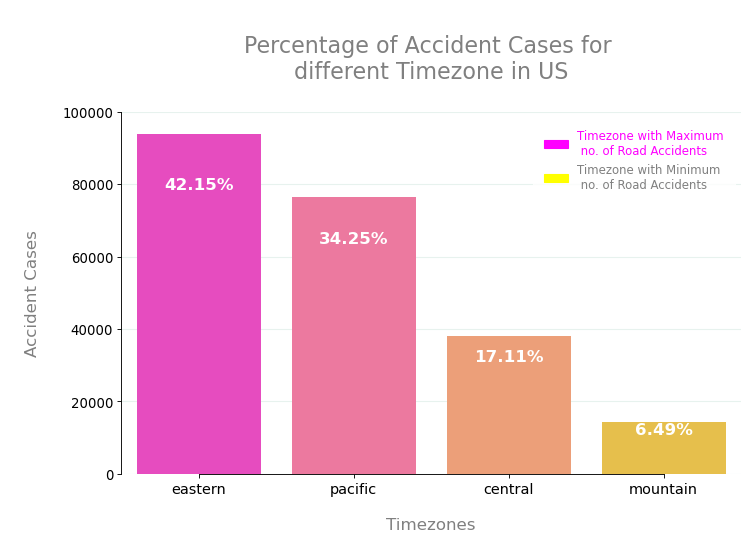

In [130]:
import matplotlib.cm as cm

plt.figure(figsize=(15, 8))

# Assuming timezone_df is already loaded and contains the 'Timezone' and 'Cases' columns

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6), dpi=80)

# Define the colormap and colors
cmap = cm.get_cmap('spring', 4)
clrs = [matplotlib.colors.rgb2hex(cmap(i)) for i in range(cmap.N)]

# Plot the barplot using Seaborn
ax = sns.barplot(y=timezone_df['Cases'], x=timezone_df['Timezone'], palette='spring')

# Calculate the total cases to determine percentages
total_cases = timezone_df['Cases'].sum()

# Loop through each bar in the barplot to add text labels
for p in ax.patches:
    # Get the height of the current bar (number of cases for that timezone)
    height = p.get_height()
    
    # Calculate the percentage for the current bar
    percentage = (height / total_cases) * 100
    
    # Place the text slightly below the top inside each bar
    ax.text(p.get_x() + p.get_width() / 2, height - height * 0.15,  # Adjusting the y position slightly down
            '{}%'.format(round(percentage, 2)), ha='center', va='center', fontsize=15, weight='bold', color='white')

# Set plot limits and labels
plt.ylim(0, 100000)
plt.title('\nPercentage of Accident Cases for \ndifferent Timezone in US\n', size=20, color='grey')
plt.ylabel('\nAccident Cases\n', fontsize=15, color='grey')
plt.xlabel('\nTimezones\n', fontsize=15, color='grey')
plt.xticks(fontsize=13)
plt.yticks(fontsize=12)

# Remove the top and right spines
for i in ['top', 'right']:
    side = ax.spines[i]
    side.set_visible(False)

# Set grid and spine properties
ax.set_axisbelow(True)
ax.grid(color='#b2d6c7', linewidth=1, axis='y', alpha=.3)
ax.spines['bottom'].set_bounds(0.005, 3)
ax.spines['left'].set_bounds(0, 100000)

# Create legend patches
MA = mpatches.Patch(color=clrs[0], label='Timezone with Maximum\n no. of Road Accidents')
MI = mpatches.Patch(color=clrs[-1], label='Timezone with Minimum\n no. of Road Accidents')

# Add the legend to the plot
ax.legend(handles=[MA, MI], prop={'size': 10.5}, loc='best', borderpad=1, 
          labelcolor=[clrs[0], 'grey'], edgecolor='white')

# Save the figure to a file
plt.savefig('timezone.png', bbox_inches='tight')

# Show the plot
plt.show()


<b> Eastern timezone has the highest percentage of accident cases of about 42.15% while mountain timezone has the least percentage of accident cases of about 6.49% <b>

#### Severity of accidents for each weather condition

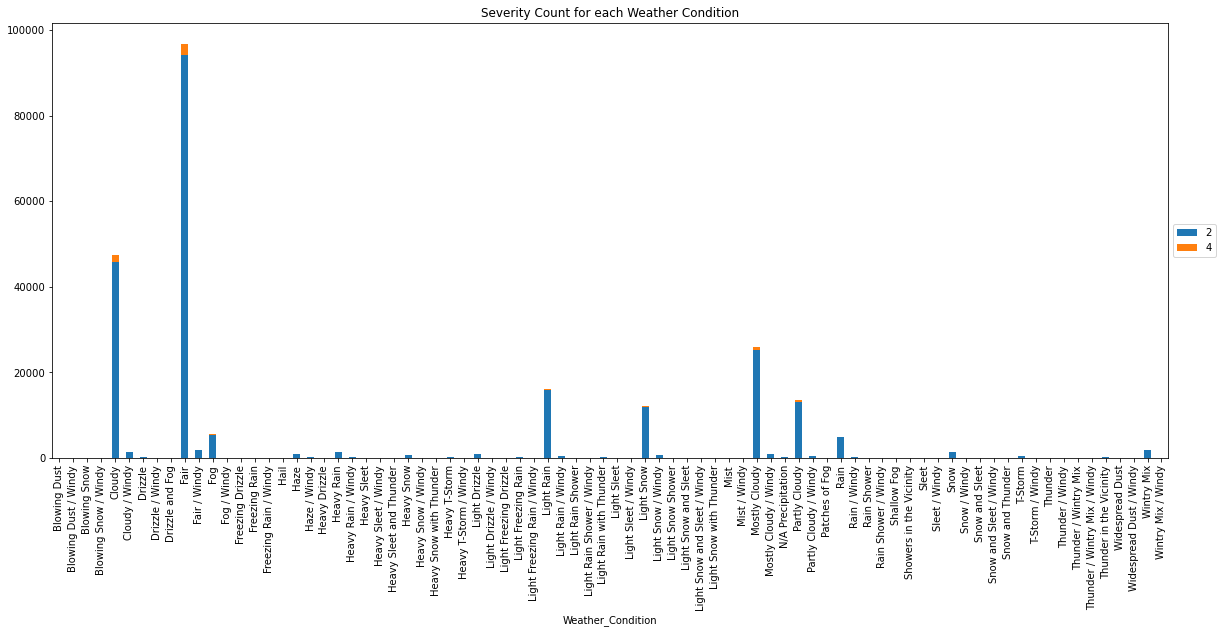

In [126]:
weather_accidents = accidents.groupby(['Weather_Condition', 'Severity']).size().reset_index().pivot(columns='Severity', 
                                                                      index='Weather_Condition', values=0)

weather_accidents.plot(kind='bar', stacked=True, figsize=(20,8), title='Severity Count for each Weather Condition').legend(loc='center left',
                                                                                        bbox_to_anchor=(1.0, 0.5))
# Save the figure to a file
plt.savefig('weather_condition.png', bbox_inches='tight')

<b> There appears to have been the highest number of incidents in fair weather. This is worth investigating further as it might suggest wrong categorical labelling. <b>

#### Load the data into a local DB using SQLite

In [287]:
# Load the SQL extension in Jupyter
%load_ext sql


connection = sqlite3.connect('helcim.db')
accidents.to_sql(name = 'accidents', con = connection, if_exists = 'replace', index = False)

# to check if connection works, run
pd.read_sql_query('select count(*) from accidents', connection)

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


,count(*)
0,245814


In [288]:
df = pd.read_sql_query('SELECT * FROM accidents', connection)
df.head()

,ID,Source,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),...,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
0,A-3650461,Source1,2,2023-03-31 17:09:16,2023-03-31 18:09:49,45.676472,-94.174568,45.666976,-94.176184,0.660999999999999,...,0.0,0.0,0.0,0.0,0.0,0.0,Day,Day,Day,Day
1,A-3650462,Source1,2,2023-02-27 20:55:00,2023-02-27 23:36:34,41.391812,-75.467365,41.39837,-75.484203,0.983,...,0.0,0.0,0.0,0.0,0.0,0.0,Night,Night,Night,Night
2,A-3650463,Source1,2,2023-02-26 09:31:45,2023-02-26 11:58:19,40.850278,-73.94614,40.846945,-73.933651,0.692,...,0.0,0.0,0.0,0.0,0.0,0.0,Day,Day,Day,Day
3,A-3650464,Source1,2,2023-03-21 17:46:42,2023-03-21 18:31:50,33.71499181,-84.30018783,33.71453181,-84.266758,1.922,...,0.0,0.0,0.0,0.0,0.0,0.0,Day,Day,Day,Day
4,A-3650465,Source1,2,2023-03-24 04:46:30,2023-03-24 09:22:00,33.927671,-118.266385,33.929608,-118.343065,4.398,...,0.0,0.0,0.0,0.0,0.0,0.0,Night,Night,Night,Night


## 3.

In [289]:
query = """
WITH CleanedData AS (
    -- Step 1: Drop rows with missing 'Timezone' and create a column for UTC offset
    SELECT *,
        CASE 
            WHEN Timezone LIKE '%eastern%' THEN -5
            WHEN Timezone LIKE '%central%' THEN -6
            WHEN Timezone LIKE '%mountain%' THEN -7
            WHEN Timezone LIKE '%pacific%' THEN -8
            ELSE NULL
        END AS UTC_Offset
    FROM accidents
    WHERE Timezone IS NOT NULL
),
FilteredTemperature AS (
    -- Step 2: Filter out invalid values in Temperature_Range(F)
    SELECT * 
    FROM CleanedData
    WHERE `Temperature_Range(F)` IS NOT NULL
    AND (`Temperature_Range(F)` LIKE '% - %' OR CAST(`Temperature_Range(F)` AS TEXT) NOT LIKE '%[a-zA-Z]%')
),
ImputedData AS (
    -- Step 3: Impute missing data in Temperature_Range(F)
    SELECT *,
        COALESCE(`Temperature_Range(F)`, (SELECT AVG(CAST(`Temperature_Range(F)` AS FLOAT)) FROM FilteredTemperature)) AS Imputed_Temperature_Range
    FROM FilteredTemperature
),
MedianTemperature AS (
    -- Step 4: Calculate the median temperature in Celsius for each row
    SELECT *,
        -- Calculate median if range is given
        CASE 
            WHEN Imputed_Temperature_Range LIKE '% - %' THEN
                ((CAST(SUBSTR(Imputed_Temperature_Range, 1, INSTR(Imputed_Temperature_Range, '-')-1) AS FLOAT) +
                  CAST(SUBSTR(Imputed_Temperature_Range, INSTR(Imputed_Temperature_Range, '-')+1, LENGTH(Imputed_Temperature_Range)) AS FLOAT)) / 2)
            -- If it's a single temperature, use that value directly
            ELSE CAST(Imputed_Temperature_Range AS FLOAT)
        END AS median_temp_fahrenheit,
        -- Convert to Celsius
        (((CASE 
            WHEN Imputed_Temperature_Range LIKE '% - %' THEN
                ((CAST(SUBSTR(Imputed_Temperature_Range, 1, INSTR(Imputed_Temperature_Range, '-')-1) AS FLOAT) +
                  CAST(SUBSTR(Imputed_Temperature_Range, INSTR(Imputed_Temperature_Range, '-')+1, LENGTH(Imputed_Temperature_Range)) AS FLOAT)) / 2)
            ELSE CAST(Imputed_Temperature_Range AS FLOAT)
        END) - 32) * 5/9) AS median_temp_celsius
    FROM ImputedData
),
AvgTempPerLocation AS (
    -- Step 5: Calculate the average temperature per location per time
    SELECT *,
        AVG(median_temp_celsius) OVER(PARTITION BY State, strftime('%H', Start_Time)) AS avg_temp_per_location
    FROM MedianTemperature
)
-- Step 6: Calculate the temperature difference between median_temp_celsius and avg_temp_per_location
SELECT *,
    (median_temp_celsius - avg_temp_per_location) AS temp_difference
FROM AvgTempPerLocation;
"""

# To execute the query, you would run this in your Jupyter Notebook
import sqlite3
import pandas as pd

# Establish a connection to your SQLite database
connection = sqlite3.connect('helcim.db')

# Execute the query and load the result into a DataFrame
df = pd.read_sql_query(query, connection)

# Show the first few rows of the DataFrame to verify the output
df.head()


,ID,Source,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),...,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight,UTC_Offset,Imputed_Temperature_Range,median_temp_fahrenheit,median_temp_celsius,avg_temp_per_location,temp_difference
0,A-3833978,Source1,2,2023-01-01 00:16:45,2023-01-01 02:01:45,34.749095,-86.802403,34.749271,-86.806356,0.225,...,Night,Night,Night,Night,-6,57.0 - 61.0,59.0,15.000000,9.479167,5.520833
1,A-4057561,Source1,2,2023-01-29 00:21:30,2023-01-29 02:45:00,34.752056,-86.750222,34.752133,-86.749769,0.026,...,Night,Night,Night,Night,-6,52.0 - 56.0,54.0,12.222222,9.479167,2.743056
2,A-4139190,Source1,2,2023-01-19 00:08:27,2023-01-19 01:53:27,34.8461469999999,-86.712721,34.846359,-86.712914,0.018,...,Night,Night,Night,Night,-6,65.0 - 69.0,67.0,19.444444,9.479167,9.965278
3,A-4627981,Source1,2,2023-01-16 00:47:02,2023-01-16 02:32:02,33.285015,-86.800876,33.28269,-86.800695,0.161,...,Night,Night,Night,Night,-6,32.0 - 36.0,34.0,1.111111,9.479167,-8.368056
4,A-4637293,Source1,2,2023-01-22 00:00:31,2023-01-22 01:45:31,34.737592,-86.606086,34.737865,-86.605463,0.04,...,Night,Night,Night,Night,-6,41.0 - 45.0,43.0,6.111111,9.479167,-3.368056


Upon inspection 

## 4 : 

### I have used only 0.5% of the dataset to train the model for illustrative purpose. This is due to limited computational resource and processing time.

### Factors Affecting Lenght of Road Affected by Accidents Using A Random Forest Regression Model

In [294]:
# df.to_csv('accidents_ml.csv', index = False)

In [15]:
# df = pd.read_csv('accidents_ml.csv')

#### Handling missing values. 
We will drop the null values

In [16]:
# Drop missing values
df = df.dropna()

#### Feature selection

We will select only features that are relevant to our model

In [17]:
# Convert the times to hour
df['Start_Time'] = pd.to_datetime(df['Start_Time']).dt.hour
df['End_Time'] = pd.to_datetime(df['End_Time']).dt.hour
df['Weather_Timestamp'] = pd.to_datetime(df['Weather_Timestamp']).dt.hour

In [18]:
df = df[['Severity', 'Start_Time', 'End_Time', 'Start_Lat','Start_Lng', 'End_Lat', 'End_Lng', 'Distance(mi)', 'City', 'County', 'State', 'Timezone', 'Weather_Timestamp', 'Wind_Chill(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Direction', 'Wind_Speed(mph)', 'Precipitation(in)', 'Weather_Condition', 'Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop', 'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight', 'Astronomical_Twilight', 'UTC_Offset', 'median_temp_celsius', 'avg_temp_per_location', 'temp_difference']]

#### Checking for correlation and removing highly correlated features

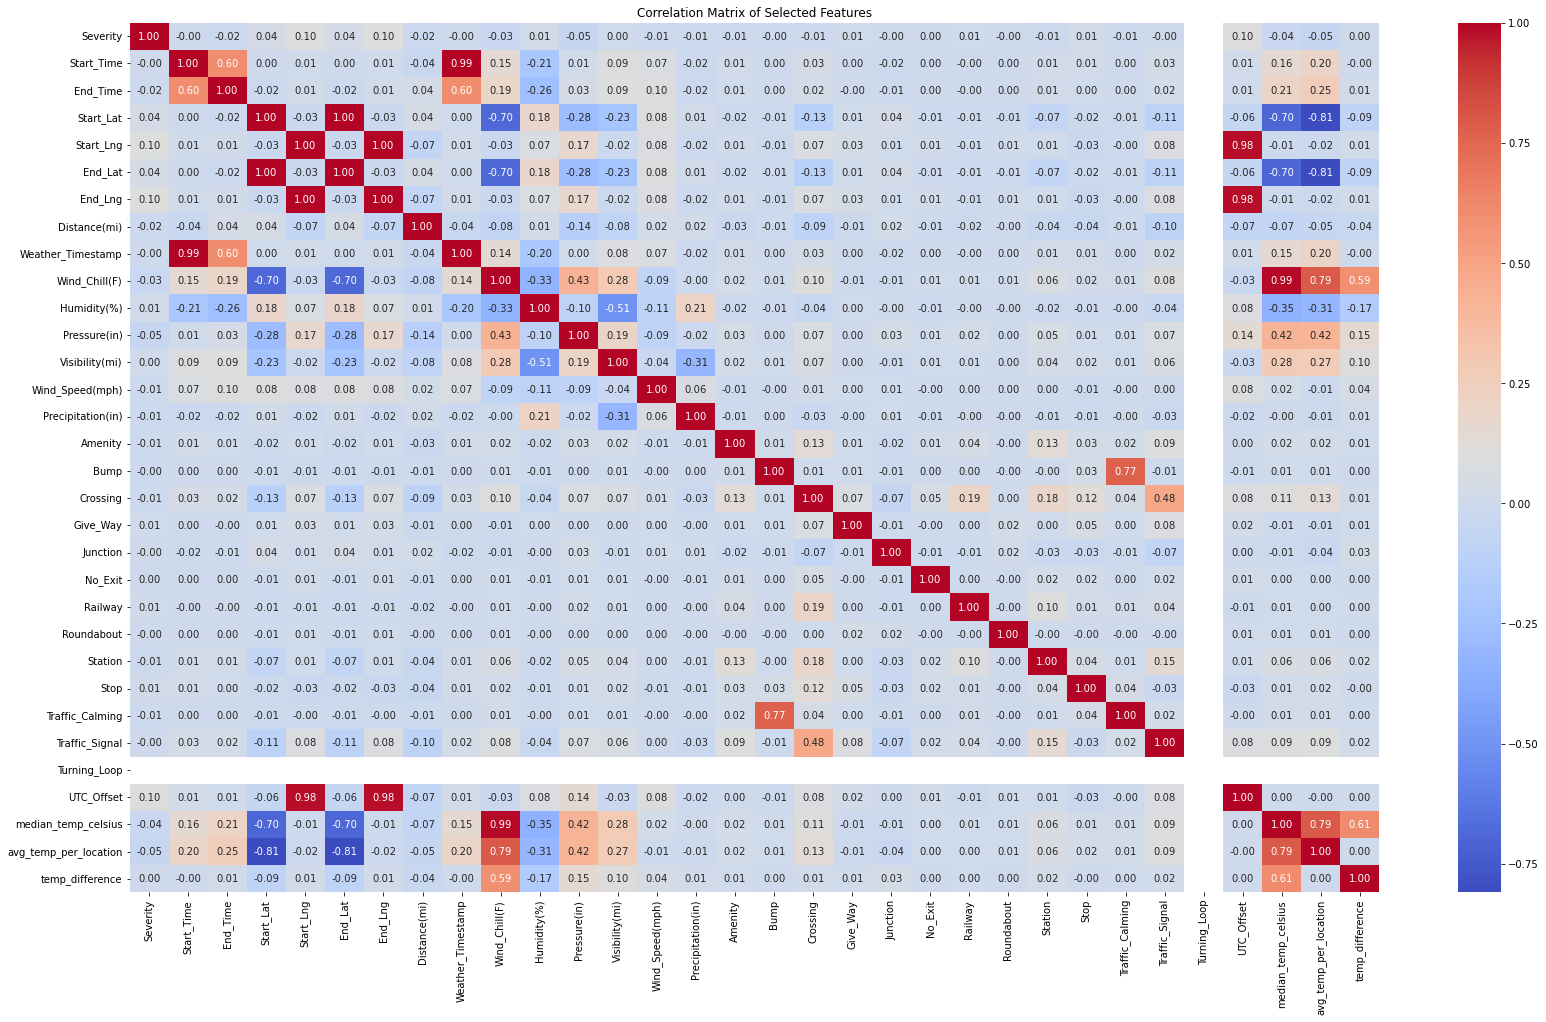

Highly correlated features (correlation > 0.3):
['End_Time', 'End_Lat', 'End_Lng', 'Weather_Timestamp', 'Wind_Chill(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Precipitation(in)', 'Traffic_Calming', 'Traffic_Signal', 'UTC_Offset', 'median_temp_celsius', 'avg_temp_per_location', 'temp_difference']
Features remaining after removing highly correlated ones:

Index(['Severity', 'Start_Time', 'Start_Lat', 'Start_Lng', 'Distance(mi)',
       'City', 'County', 'State', 'Timezone', 'Pressure(in)', 'Visibility(mi)',
       'Wind_Direction', 'Wind_Speed(mph)', 'Weather_Condition', 'Amenity',
       'Bump', 'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout',
       'Station', 'Stop', 'Turning_Loop', 'Sunrise_Sunset', 'Civil_Twilight',
       'Nautical_Twilight', 'Astronomical_Twilight', 'UTC_Offset',
       'avg_temp_per_location'],
      dtype='object')


In [19]:
# Compute the correlation matrix
corr_matrix = df.corr()

# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(28, 16))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Selected Features')
plt.show()

# Step 3: Identify highly correlated features
# We will use the absolute value of the correlation matrix to make it easier
corr_matrix_abs = corr_matrix.abs()

# Create a mask to ignore the upper triangle and the diagonal of the correlation matrix
upper_triangle_mask = np.triu(np.ones(corr_matrix_abs.shape), k=1).astype(bool)

# Extract upper triangle of the correlation matrix
upper_triangle = corr_matrix_abs.where(upper_triangle_mask)

# Find features with correlation greater than the threshold (e.g., 0.3)
threshold = 0.3
high_corr_features = [column for column in upper_triangle.columns if any(upper_triangle[column] > threshold)]

print(f"Highly correlated features (correlation > {threshold}):")
print(high_corr_features)

# Step 4: Drop one of each pair of highly correlated features
df_select_features = df.drop(columns = ['Weather_Timestamp', 'End_Lng', 'Wind_Chill(F)', 'End_Lng', 'End_Lat', 'median_temp_celsius', 'Traffic_Calming', 
                                        'temp_difference', 'End_Time', 'Humidity(%)', 'Crossing', 'Traffic_Signal', 'Precipitation(in)'])

print("Features remaining after removing highly correlated ones:")
print()
print(df_select_features.columns)


For each highly correlated pair, we chose to drop one of the features. The selection can be based on domain knowledge and feature importance.

#### Training the model and selecting required features

In [20]:
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, KFold, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Step 1: Split the data into training, validation, and test sets
df = df_select_features.copy()

# Select 0.5% of the dataset
df = df.sample(frac=0.005, random_state=42)

# Display the size of the sampled dataset to verify
print(f"Original dataset size: {df_select_features.shape}")
print(f"Sampled dataset size: {df.shape}")

# Define the predictor (X) and target variable (y)
X = df.drop('Distance(mi)', axis=1)
y = df['Distance(mi)']

# Split the data into training+validation and test sets (80/20 split)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Further split the training+validation set into training and validation sets (80/20 split)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

# Step 2: Carry out one-hot encoding for categorical variables and feature scaling for numerical variables
# List of categorical features to encode
categorical_features = ['Severity', 'City', 'County', 'State', 'Timezone', 'Wind_Direction', 'Weather_Condition', 
                        'Amenity', 'Bump', 'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 
                        'Station', 'Stop', 'Turning_Loop', 'Sunrise_Sunset', 'Civil_Twilight', 
                        'Nautical_Twilight', 'Astronomical_Twilight', 'UTC_Offset']



# List of numerical features to scale
numerical_features = ['Start_Time', 'Start_Lat', 'Start_Lng', 
                      'Pressure(in)', 'Visibility(mi)', 'Wind_Speed(mph)', 'avg_temp_per_location']

Original dataset size: (228274, 30)
Sampled dataset size: (1141, 30)


In [21]:
df.columns

Index(['Severity', 'Start_Time', 'Start_Lat', 'Start_Lng', 'Distance(mi)',
       'City', 'County', 'State', 'Timezone', 'Pressure(in)', 'Visibility(mi)',
       'Wind_Direction', 'Wind_Speed(mph)', 'Weather_Condition', 'Amenity',
       'Bump', 'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout',
       'Station', 'Stop', 'Turning_Loop', 'Sunrise_Sunset', 'Civil_Twilight',
       'Nautical_Twilight', 'Astronomical_Twilight', 'UTC_Offset',
       'avg_temp_per_location'],
      dtype='object')

In [22]:
# Use ColumnTransformer to apply one-hot encoding to categorical columns and scaling to numerical columns
column_transformer = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', sparse=False, handle_unknown = 'ignore'), categorical_features),
        ('num', StandardScaler(), numerical_features)
    ], remainder='passthrough'
)


In [23]:
# Step 3: Initialize Random Forest Regressor and perform 5-fold cross-validation
rf = RandomForestRegressor(random_state=42)

# Set up the pipeline for preprocessing and modeling
pipeline = Pipeline(steps=[('preprocessor', column_transformer), ('model', rf)])


In [24]:
# Use 5-fold cross-validation to ensure model generalization ability
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cross_val_scores = cross_val_score(pipeline, X_train, y_train, cv=kf, scoring='neg_mean_squared_error')


In [25]:
# Fit the model on the training data
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse=False),
                                                  ['Severity', 'City', 'County',
                                                   'State', 'Timezone',
                                                   'Wind_Direction',
                                                   'Weather_Condition',
                                                   'Amenity', 'Bump',
                                                   'Give_Way', 'Junction',
                                                   'No_Exit', 'Railway',
                                                   'Roundabout', 'Station',
                

In [26]:
# Step 4: Use the trained model to predict Distance(mi) on the validation and test datasets
y_val_pred = pipeline.predict(X_val)
y_test_pred = pipeline.predict(X_test)


In [27]:
# Step 5: Use evaluation metrics to assess the model's performance on validation and test sets
# Function to calculate and print evaluation metrics
def print_evaluation_metrics(y_true, y_pred, dataset_name="Validation"):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    print(f"{dataset_name} Set Evaluation Metrics:")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"R-squared (R2): {r2:.4f}")
    print()

# Evaluate the model on the validation set
print_evaluation_metrics(y_val, y_val_pred, dataset_name="Validation")

# Evaluate the model on the test set
print_evaluation_metrics(y_test, y_test_pred, dataset_name="Test")



Validation Set Evaluation Metrics:
Mean Absolute Error (MAE): 1.0168
Mean Squared Error (MSE): 5.1950
Root Mean Squared Error (RMSE): 2.2792
R-squared (R2): -0.2687

Test Set Evaluation Metrics:
Mean Absolute Error (MAE): 0.8567
Mean Squared Error (MSE): 4.1052
Root Mean Squared Error (RMSE): 2.0261
R-squared (R2): -0.0575



In [28]:
# Step 6: Use GridSearchCV and RandomizedSearchCV for hyperparameter tuning

# Define the parameter grid for GridSearchCV
param_grid = {
    'model__n_estimators': [50, 100, 200],
    'model__max_depth': [None, 10, 20, 30],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4],
    'model__max_features': ['auto', 'sqrt', 'log2']
}

# Initialize GridSearchCV with 5-fold cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=2)

# Fit GridSearchCV to the training data
grid_search.fit(X_train, y_train)



Fitting 5 folds for each of 324 candidates, totalling 1620 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('cat',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignore',
                                                                                       sparse=False),
                                                                         ['Severity',
                                                                          'City',
                                                                          'County',
                                                                          'State',
                                                                          'Timezone',
                          

In [29]:
# Define the parameter grid for RandomizedSearchCV
param_dist = {
    'model__n_estimators': np.arange(50, 201, 50),
    'model__max_depth': [None, 10, 20, 30, 40, 50],
    'model__min_samples_split': np.arange(2, 11, 2),
    'model__min_samples_leaf': np.arange(1, 5),
    'model__max_features': ['auto', 'sqrt', 'log2']
}

# Initialize RandomizedSearchCV with 5-fold cross-validation
random_search = RandomizedSearchCV(pipeline, param_dist, cv=5, scoring='neg_mean_squared_error', n_iter=100, n_jobs=-1, random_state=42, verbose=2)

# Fit RandomizedSearchCV to the training data
random_search.fit(X_train, y_train)



Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('cat',
                                                                               OneHotEncoder(drop='first',
                                                                                             handle_unknown='ignore',
                                                                                             sparse=False),
                                                                               ['Severity',
                                                                                'City',
                                                                                'County',
                                                                                'State',
                                              

In [30]:
# Step 7: Refit the model with the best-found hyperparameters and retrain on the entire training dataset
best_rf_model = random_search.best_estimator_

# Refit the model on the combined training and validation set
best_rf_model.fit(X_train_val, y_train_val)



Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse=False),
                                                  ['Severity', 'City', 'County',
                                                   'State', 'Timezone',
                                                   'Wind_Direction',
                                                   'Weather_Condition',
                                                   'Amenity', 'Bump',
                                                   'Give_Way', 'Junction',
                                                   'No_Exit', 'Railway',
                                                   'Roundabout', 'Station',
                

In [31]:
# Step 8: Evaluate the refitted model on the test set
y_test_best_pred = best_rf_model.predict(X_test)



In [32]:
# Evaluate the model on the test set with the best-found hyperparameters
print_evaluation_metrics(y_test, y_test_best_pred, dataset_name="Test (Best Model)")



Test (Best Model) Set Evaluation Metrics:
Mean Absolute Error (MAE): 0.9476
Mean Squared Error (MSE): 3.6378
Root Mean Squared Error (RMSE): 1.9073
R-squared (R2): 0.0629



In [33]:
# Step 9: Analyze feature importance
# Extract the Random Forest model from the pipeline
rf_best = best_rf_model.named_steps['model']



In [34]:
# Get feature names after one-hot encoding
encoded_feature_names = best_rf_model.named_steps['preprocessor'].transformers_[0][1].get_feature_names_out(categorical_features)
feature_names = np.append(encoded_feature_names, X_train.drop(columns=categorical_features).columns)



In [35]:
# Get feature importances from the Random Forest model
feature_importances = rf_best.feature_importances_



In [36]:
# Create a DataFrame to display feature importance
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
feature_importance_df.sort_values(by='Importance', ascending=False, inplace=True)



In [38]:
print("Feature Importances:")
print(feature_importance_df.head(10))

Feature Importances:
                          Feature  Importance
946                  Pressure(in)    0.091962
947                Visibility(mi)    0.090008
719                 County_Nevada    0.082509
949         avg_temp_per_location    0.058136
944                     Start_Lat    0.041092
924        Weather_Condition_Snow    0.040754
890             Wind_Direction_NW    0.036704
945                     Start_Lng    0.036349
830                      State_AR    0.034741
913  Weather_Condition_Light Snow    0.032826


### Our Random Forest Regressor model shows that the top 6 factors below affect the length of the roads affected by car accidents the most

* Pressure -  Shows the air pressure (in inches).
* Visibility - Shows visibility (in miles).
* avg_temp_per_location - Average temperature per location.
* Start_Lat and Start_Lng - The GPS coordinates of the start point of the accident.
* Weather_Condition_Snow - The presence of snow.
* Wind_Direction_NW - Wind blowing in the North-West direction.